In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
import os 

In [5]:
df_list = []
for file in os.listdir("../data/vanilla"): 
    df = pd.read_csv("../data/vanilla/" + file, sep = ",")
    df.columns = ["number_particles", "cluster_radius"]
    df.number_particles = df.number_particles.apply(lambda x : int(x.strip("number_particles:")))
    df.cluster_radius = df.cluster_radius.apply(lambda x : float(x.strip("cluster_radius:")))
    df = df.drop(columns = "number_particles")
    df_list.append(df)

In [7]:
df = pd.concat(df_list, axis = 1)

In [9]:
df

,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,...,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius,cluster_radius
0,1.000000,2.000000,1.00000,1.000000,1.414214,1.000000,1.414214,2.000000,2.000000,1.000000,...,1.414214,1.000000,1.000000,2.000000,1.000000,1.414214,1.414214,2.000000,1.414214,2.000000
1,2.000000,2.236068,2.00000,1.000000,1.414214,1.414214,1.414214,2.000000,2.000000,2.000000,...,2.236068,1.414214,1.414214,2.000000,1.414214,1.414214,2.000000,2.000000,2.236068,2.236068
2,2.000000,2.236068,2.00000,2.000000,2.236068,1.414214,2.236068,2.236068,3.000000,2.000000,...,2.236068,2.000000,1.414214,2.236068,2.000000,2.000000,3.000000,2.000000,2.236068,3.162278
3,3.000000,2.236068,2.00000,2.236068,2.236068,2.236068,2.236068,3.000000,3.162278,2.236068,...,3.162278,2.000000,1.414214,3.162278,3.000000,2.236068,4.000000,2.000000,2.236068,3.162278
4,3.000000,2.236068,2.00000,2.828427,2.236068,2.236068,2.236068,3.162278,4.000000,2.828427,...,3.162278,2.000000,2.000000,3.162278,3.000000,2.236068,4.000000,2.236068,2.236068,4.123106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,140.801278,152.085502,139.55644,125.419297,141.650980,124.523090,150.000000,139.215660,144.516435,145.464772,...,135.074054,136.124943,148.276768,133.820776,129.123971,149.120756,135.299667,122.918672,127.349912,132.378246
4994,140.801278,152.085502,139.55644,125.419297,141.650980,124.523090,150.000000,139.215660,144.516435,145.464772,...,135.074054,136.124943,148.276768,133.820776,129.123971,149.120756,135.299667,122.918672,127.349912,132.378246
4995,140.801278,152.085502,139.55644,125.419297,141.650980,124.523090,150.000000,139.215660,144.516435,145.464772,...,135.074054,136.124943,148.276768,133.820776,129.123971,149.120756,135.299667,122.918672,127.349912,132.378246
4996,140.801278,152.085502,139.55644,125.419297,141.908421,124.523090,150.000000,139.215660,144.516435,145.464772,...,135.074054,136.124943,148.276768,133.820776,129.123971,149.120756,135.299667,122.918672,127.349912,132.378246


In [10]:
df['cluster_radius_avg'] = df.mean(axis=1)
df['cluster_radius_std'] = df.std(axis=1)
df = df.drop(columns = "cluster_radius")

In [11]:
df['num_particles'] = [x for x in range(len(df))]

In [12]:
data_mask = np.logical_and(np.isfinite(np.log(df.num_particles)),  np.isfinite(np.log(df.cluster_radius_avg)))

/home/cm2435/anaconda3/envs/pytorch_test/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cluster_radius_avg,cluster_radius_std,num_particles
0,1.416609,0.415822,0
1,1.802479,0.434247,1
2,2.181960,0.556206,2
3,2.454124,0.552631,3
4,2.743030,0.636768,4
...,...,...,...
4993,136.140354,8.663367,4993
4994,136.142039,8.663050,4994
4995,136.144769,8.664324,4995
4996,136.146781,8.665631,4996


In [53]:
log_num_particle = np.log(df.num_particles)[data_mask]
log_cluster_rad = np.log(df.cluster_radius_avg)[data_mask]
cluster_rad_err =  (df.cluster_radius_std / df.cluster_radius_avg).values[data_mask]

/home/cm2435/anaconda3/envs/pytorch_test/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
log_num_particle = np.array([x for i, x in enumerate(log_num_particle) if i%2==0])
log_cluster_rad =  np.array([x for i, x in enumerate(log_cluster_rad) if i%2==0])
cluster_rad_err =  np.array([x for i, x in enumerate(cluster_rad_err) if i%2==0])

In [57]:
log_num_particle > 1.5

1       False
2       False
3       False
4       False
5        True
        ...  
4993     True
4994     True
4995     True
4996     True
4997     True
Name: num_particles, Length: 4997, dtype: bool

1.7507069626992104 -0.07999371326791582


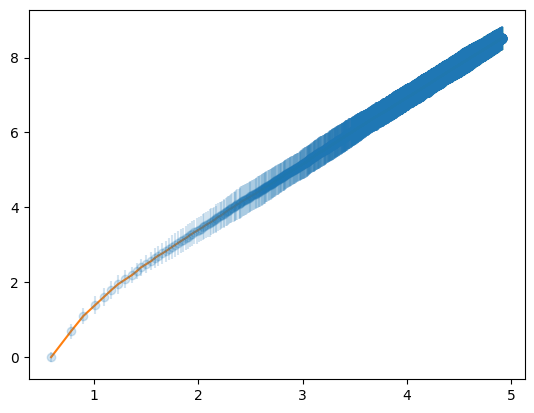

In [63]:
from scipy import stats

#plt.errorbar(log_cluster_rad, log_num_particle)
plt.errorbar(log_cluster_rad, log_num_particle, yerr=log_cluster_rad * cluster_rad_err, fmt='o', alpha =0.2)
plt.plot(log_cluster_rad, log_num_particle)

data_mask_point = log_num_particle > 2
slope, intercept, r_value, p_value, std_err = stats.linregress(log_cluster_rad[data_mask_point], log_num_particle[data_mask_point])
print(slope, intercept)
plt.show()

In [56]:
log_num_particle


1       0.000000
2       0.693147
3       1.098612
4       1.386294
5       1.609438
          ...   
4993    8.515792
4994    8.515992
4995    8.516193
4996    8.516393
4997    8.516593
Name: num_particles, Length: 4997, dtype: float64